In [84]:
import pandas as pd
from bokeh.io import output_file, show, output_notebook, reset_output
from bokeh.plotting import figure

import networkx as nx
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx
from bokeh.layouts import gridplot
from scipy.stats import chi2_contingency, fisher_exact


from src.graph import Graph, GraphBuilder
from src.utils import write_single_csv

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [85]:
reset_output()
output_notebook()

Loading BokehJS ...

In [86]:
def graph_from_args(args) -> Graph:
    return GraphBuilder() \
        .with_num_nodes(args["num_nodes"]) \
        .with_edge_density(args["edge_density"]) \
        .with_discrete_node_ratio(args["discrete_node_ratio"]) \
        .with_discrete_signal_to_noise_ratio(args["discrete_signal_to_noise_ratio"]) \
        .with_min_discrete_value_classes(args["min_discrete_value_classes"]) \
        .with_max_discrete_value_classes(args["max_discrete_value_classes"]) \
        .with_continuous_noise_std(args["continuous_noise_std"]) \
        .with_continuous_beta_mean(args["continuous_beta_mean"]) \
        .with_continuous_beta_std(args["continuous_beta_std"]) \
        .build()

args = {}
args["num_nodes"] = 3
args["num_samples"] = 810
args["edge_density"] = 0.4
args["discrete_node_ratio"] = 1.0
args["discrete_signal_to_noise_ratio"] = 0.9
args["min_discrete_value_classes"] = 3
args["max_discrete_value_classes"] = 4
args["continuous_noise_std"] = 1.0
args["continuous_beta_mean"] = 1.0
args["continuous_beta_std"] = 1.0
args["num_processes"] = 1

graph_from_args(args)
G = graph_from_args(args)
dfs = G.sample(num_observations=args["num_samples"], num_processes=args["num_processes"])
df = pd.concat(dfs, copy=False)
df = df.reindex(sorted(df.columns), axis=1)

ground_truth = G.to_networkx_graph()
df.head()

,0,1,2
0,0,1,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


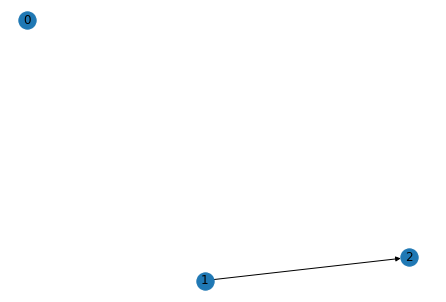

In [87]:
nx.draw_spring(ground_truth, with_labels = True)

root_nodes = list(set(list(ground_truth.nodes)) - set([edge[1] for edge in ground_truth.edges]))

In [88]:
plots = []
for column in df.columns:
    discrete_values = df[column].unique()
    counts = list(df[column].value_counts())
    
    root_info = f"Root" if column in root_nodes else ""
    
    p = figure(plot_height=250, title=f"Node: {column} {root_info}",
               toolbar_location=None, tools="")

    p.vbar(x=discrete_values, top=counts, width=0.9)

    p.xgrid.grid_line_color = None
    p.y_range.start = 0

    plots.append(p)
    
# make a grid
grid = gridplot(plots, ncols=int(len(df.columns) / 2) + 1, plot_width=250, plot_height=250)

show(grid)

In [89]:
num_values = len(df.columns)
nodes = df.columns

In [90]:
mask = np.ones([num_values, num_values])
true_values = np.zeros([num_values, num_values])
for edge in ground_truth.edges:
    x = int(edge[0])
    y = int(edge[1])
    true_values[x][y] = 1
    true_values[y][x] = 1
    
p_values = []
for column_index, column in enumerate(nodes):
    row_p_values = []
    for row_index, row in enumerate(nodes):
        ct = pd.crosstab(df[column], df[row])
        #display(ct)
        stat, p_value, degrees_of_freedom, expected = chi2_contingency(ct)
        row_p_values.append(p_value)
        
        if column_index > row_index:
            mask[column_index, row_index] = False
        
    p_values.append(row_p_values)
    
p_values = np.array(p_values)

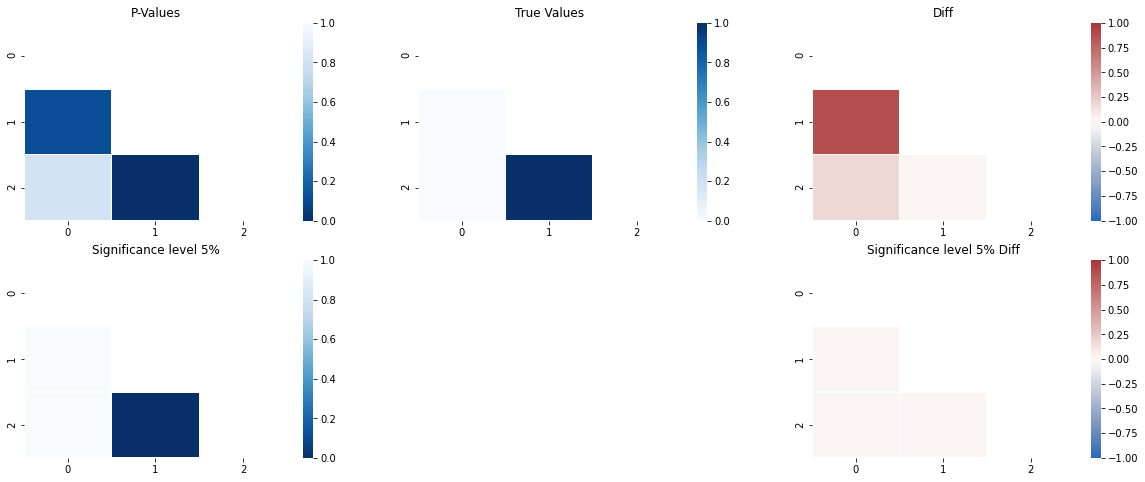

In [91]:
fig = plt.figure(figsize=(20,8))

fig.subplots_adjust()

ax = fig.add_subplot(2, 3, 1)
ax.title.set_text('P-Values')
sns.heatmap(
    p_values,
    xticklabels=df.columns,
    yticklabels=df.columns,
    mask=mask,
    linewidths=.5,
    cmap="Blues_r",
    ax=ax,
    vmin=0, vmax=1
)

ax = fig.add_subplot(2, 3, 2)
ax.title.set_text('True Values')
sns.heatmap(
    true_values,
    xticklabels=df.columns,
    yticklabels=df.columns,
    mask=mask,
    linewidths=.5,
    cmap="Blues",
    ax=ax,
    vmin=0, vmax=1
)

ax = fig.add_subplot(2, 3, 3)
ax.title.set_text('Diff')

flip_bool = lambda t: not t
vfunc = np.vectorize(flip_bool)
flipped_true_values = vfunc(true_values)

hm_data =  flipped_true_values - p_values 
sns.heatmap(
    hm_data,
    xticklabels=df.columns,
    yticklabels=df.columns,
    mask=mask,
    linewidths=.5,
    cmap="vlag",
    vmin=-1, vmax=1
)

ax = fig.add_subplot(2, 3, 4)
ax.title.set_text('Significance level 5%')

significance = lambda v: v > 0.05
vfunc = np.vectorize(significance)
significance_values = vfunc(p_values)

sns.heatmap(
    significance_values,
    xticklabels=df.columns,
    yticklabels=df.columns,
    mask=mask,
    linewidths=.5,
    cmap="Blues_r",
    vmin=0, vmax=1
)

ax = fig.add_subplot(2, 3, 6)
ax.title.set_text('Significance level 5% Diff')

hm_data =  flipped_true_values.astype(int) - significance_values.astype(int) 
sns.heatmap(
    hm_data,
    xticklabels=df.columns,
    yticklabels=df.columns,
    mask=mask,
    linewidths=.5,
    cmap="vlag",
    vmin=-1, vmax=1
)

plt.show()

In [92]:
#blau --> hat ne edge vergessen
#weiß --> hat edge korrekt vorhergesagt
#red --> hat edge vorausgesagt, ist aber keine da

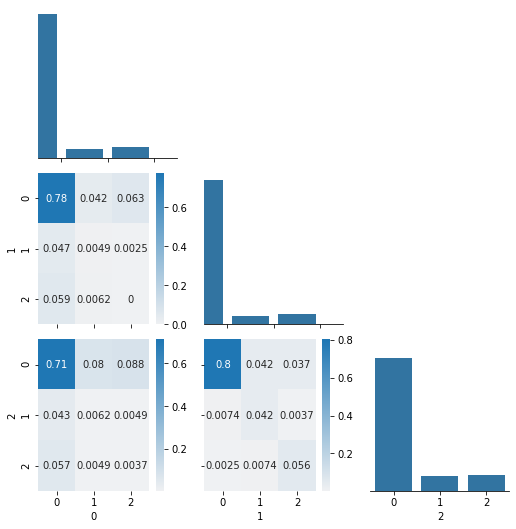

In [93]:
#df = df / args["num_samples"]

g = sns.PairGrid(df, corner=True)
def pairgrid_countplot(x, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    sns.countplot(x, cmap=cmap, **kws)
    
g.map_diag(sns.countplot,  color=sns.color_palette("tab10")[0])

def sns_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    sns.heatmap(pd.crosstab(df[x.name], df[y.name]) / args["num_samples"], cmap=cmap, annot=True)

g.map_offdiag(sns_heatmap)
#g._legend.remove()

In [94]:
# noise > -> edges werden weniger erkannt